In [7]:
cam_bas = gpd.read_file(filename='/mnt/ssd/education/HSI/aspirantura/CAMELS_ru/files/basin_set_full_res/HCDN_nhru_final_671.shp')

/home/dima/miniconda3/envs/ERA/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


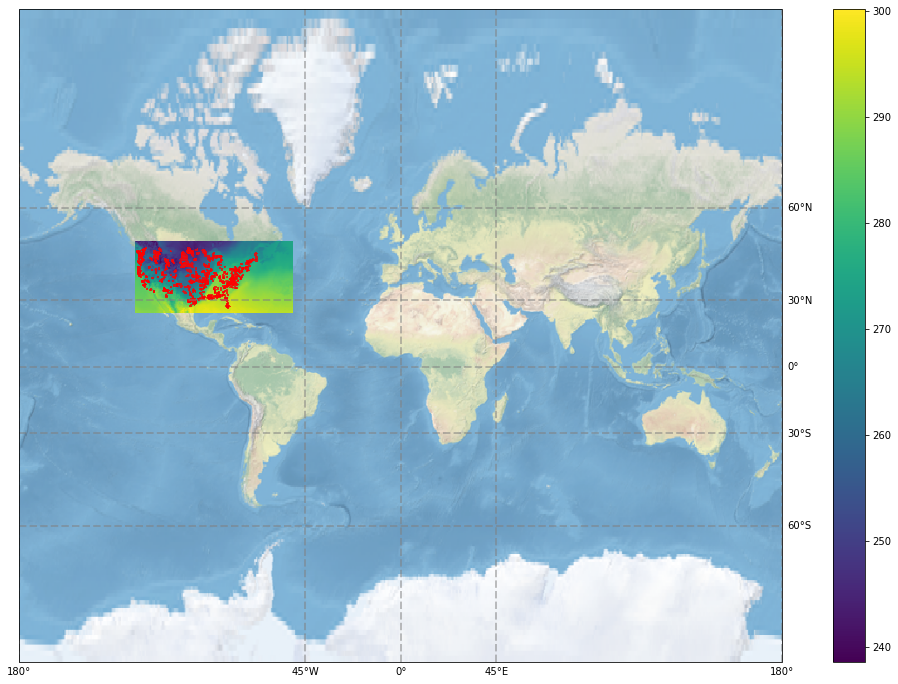

In [14]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                                   standard_parallels=(50, 70),
                                   central_latitude=56,
                                   false_easting=0,
                                   false_northing=0)

merc_crs = ccrs.Mercator()


fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=merc_crs)

ax.stock_img()
# ax.add_feature(cfeature.COASTLINE)
# ax.add_feature(cfeature.BORDERS)
#[30, 169, 38, 85]
# ax.set_extent(extent,
#               crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])


fig = plt.pcolor(test['t2m'][0].longitude, test['t2m'][0].latitude, test['t2m'][0], transform=ccrs.PlateCarree())

plt.colorbar(fig)

ax.add_geometries(cam_bas['geometry'].to_numpy(),
                  crs=ccrs.PlateCarree(),
                  edgecolor='red', 
                  alpha=0.8)

In [4]:
import xarray as xr
xr.set_options(display_style="html")
import pandas as pd
import numpy as np
np.seterr(divide='ignore')
import math
from numba import jit
 
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import cascaded_union

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as mticker

import glob
import os
import multiprocessing as mp

import time
import tqdm.notebook as tq

### Read shape files

In [2]:
ws_shapes = gpd.read_file('/mnt/e/education/HSI/aspirantura/CAMELS_ru/files/openf_gauges_watersheds/watersheds_openf.shp')
ws_shapes = ws_shapes[['code', 'name_en', 'geometry']].set_crs('epsg:4326')

In [3]:
def select_big_from_MP(WS_geometry):
    
    """
    
    Function return only biggest polygon 
    from multipolygon WS
    It's the real WS, and not malfunctioned part of it
    
    """
    if type(WS_geometry) == MultiPolygon:
        big_area = [polygon_area(lats = polygon.exterior.coords.xy[1], 
                                 lons = polygon.exterior.coords.xy[0]) 
                    for polygon in WS_geometry]
        import numpy as np
        WS_geometry = WS_geometry[np.argmax(big_area)]
    else:
        WS_geometry = WS_geometry
    return WS_geometry

def polygon_area(lats, lons, radius = 6378137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats, lons = np.deg2rad(lats), np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0]!=lats[-1]:
        lats=append(lats, lats[0])
        lons=append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats)* sin(lons/2)**2
    colat = 2*arctan2( sqrt(a), sqrt(1-a) )

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas=diff(colat)/2
    colat=colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate 
    area = abs(sum(integrands))/(4*pi)

    area = min(area,1-area)
    if radius is not None: #return in units of radius
        return area * 4 * pi* radius**2 / 10**6
    else: #return in ratio of sphere total area
        return area / 10**6

In [4]:
ws_shapes['geometry'] = [select_big_from_MP(ws) 
                         for ws in ws_shapes['geometry']]

In [5]:
def plot_check(extent, lat, lon, net_cdf_file, ws):
    
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
    from matplotlib.offsetbox import AnchoredText
    import matplotlib.ticker as mticker

    # CRS('+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

    """
    proj4_params = [('proj', 'aea'),
                    ('lon_0', central_longitude),
                    ('lat_0', central_latitude),
                    ('x_0', false_easting),
                    ('y_0', false_northing)]

    """
    aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                                   standard_parallels=(50, 70),
                                   central_latitude=56,
                                   false_easting=0,
                                   false_northing=0)

    merc_crs = ccrs.Mercator()


    fig = plt.figure(figsize=(18,12))
    ax = plt.axes(projection=aea_crs)

    ax.stock_img()
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    #[30, 169, 38, 85]
    ax.set_extent(extent,
                  crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])


    fig = plt.contourf(lon, lat, net_cdf_file, transform=ccrs.PlateCarree())

    plt.colorbar(fig)
    
    ax.add_geometries([ws_shapes.loc[0, 'geometry']],
                      crs=ccrs.PlateCarree(),
                      edgecolor='red', 
                      alpha=0.8)

    plt.show()

### E W N S
### [30, 169, 38, 85]

### From hours to days

In [8]:
'/media/dima/kek1/'

'/media/dima/kek1/'

In [9]:
# read folder with files and versions of ERA's
parent_folder = '/media/dima/kek1/ERA5_data/CONUS'
my_folder = glob.glob(parent_folder + '/*')

# list of variables
my_variables = [glob.glob(folder + '/*') for folder in my_folder]
# from glob to create single folders
single_level, prelim_level = my_variables
# list of variables (names)
variables = [var.split('/')[-1] for var in single_level]
# merge files into same category
list_of_files = dict()
for i in range(len(variables)):
    list_of_files[variables[i]]=[item for sublist in 
                                 [glob.glob(prelim_level[i] + '/*.nc'), glob.glob(single_level[i] + '/*.nc')]
                                 for item in sublist]


In [13]:
def read_netcdf(net_cdf_on_disk):
    
    """
    create variable data and variable n ame
    from information of net_cdf file
    
    net_cdf_on_disk - link to file on disk
    """
    
    dataset = xr.open_dataset(net_cdf_on_disk,
                              chunks={'time': 500})

    variable_name = list(dataset.variables)[-1]
    
    varible_data = dataset[variable_name]
    
    # calculate dayli values
    if variable_name == 't2m':
        varible_data = varible_data.resample(time='1D').mean()
        variable_data_min = varible_data.resample(time='1D').max()
        variable_data_max = varible_data.resample(time='1D').min()
    else:
        varible_data = varible_data.resample(time='1D').sum()
    
    dataset.close()
    
    return variable_name, variable_data_min, variable_data_max, varible_data

In [16]:
list(list_of_files.keys())

['2m_temperature',
 'evaporation',
 'potential_evaporation',
 'runoff',
 'total_precipitation']

In [20]:
var = '2m_temperature'

In [21]:
start_time = time.time()
print('Переносим в суточные переменные %s\n' % var)

for file_on_disk in tq.tqdm(list_of_files[var], 'Читаем файлы по %s' % var):
    
    variable_name, net_cdf_transfer_min, net_cdf_transfer_max, net_cdf_transfer = read_netcdf(file_on_disk)
    
    year = file_on_disk[-7:-3]
    
    directory = parent_folder + '/{}/{}'.format('daily',
                                                var)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    net_cdf_transfer_min.to_netcdf(directory + '/{}_min_{}.nc'.format(variable_name,
                                                                        year))
    
    net_cdf_transfer_max.to_netcdf(directory + '/{}_max_{}.nc'.format(variable_name,
                                                                        year))
    
    net_cdf_transfer.to_netcdf(directory + '/{}_{}.nc'.format(variable_name,
                                                                year))
    end_time = time.time()      
    
print("Перенос завершён за %.2f минут" % ((end_time - start_time) / 60))

Переносим в суточные переменные 2m_temperature



Читаем файлы по 2m_temperature:   0%|          | 0/71 [00:00<?, ?it/s]

Перенос завершён за 16.29 минут


In [17]:
for var in list_of_files.keys():
    start_time = time.time()
    print('Переносим в суточные переменные %s\n' % var)
    
    for file_on_disk in tq.tqdm(list_of_files[var], 'Читаем файлы по %s' % var):
        
        variable_name, net_cdf_transfer_min, net_cdf_transfer_max, net_cdf_transfer = read_netcdf(file_on_disk)
        
        year = file_on_disk[-7:-3]
        
        directory = parent_folder + '/{}/{}'.format('daily',
                                                    var)
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        net_cdf_transfer_min.to_netcdf(directory + '/{}_min_{}.nc'.format(variable_name,
                                                                          year))
        
        net_cdf_transfer_max.to_netcdf(directory + '/{}_max_{}.nc'.format(variable_name,
                                                                          year))
        
        net_cdf_transfer.to_netcdf(directory + '/{}_{}.nc'.format(variable_name,
                                                                  year))
        end_time = time.time()      
        
    print("Перенос завершён за %.2f минут" % ((end_time - start_time) / 60))
    
    
    
    

Переносим в суточные переменные 2



KeyError: '2'

In [6]:
test_file = glob.glob('/run/media/dima/kek/ERA5_data/Russia/daily/2m_temperature/' + '/*.nc')[0]
test_net_cdf = xr.open_mfdataset(test_file,
                  chunks={'time': 50})['t2m']

In [7]:
if 'latitude' in test_net_cdf.dims:
    test_net_cdf = test_net_cdf.rename({'latitude': 'lat', 'longitude': 'lon'})
else:
    pass

In [86]:
def mask_netcdf(net_cdf, shape):
    
    @jit(nopython=True, nogil=True)
    def distance(x1, y1, x2, y2):
        """
        Calculate distance from (x1,y1) to (x2,y2)
        """
        return ((x1-x2)**2 + (y1-y2)**2)**0.5

    @jit(nopython=True, nogil=True)
    def point_is_on_line(x, y, x1, y1, x2, y2):
        """
        Check whether point (x,y) is on line (x1,y1) to (x2,y2)
        """

        d1 = distance(x,  y,  x1, y1)
        d2 = distance(x,  y,  x2, y2)
        d3 = distance(x1, y1, x2, y2)

        eps = 1e-12
        return np.abs((d1+d2)-d3) < eps

    @jit(nopython=True, nogil=True)
    def is_left(xp, yp, x0, y0, x1, y1):
        """
        Check whether point (xp,yp) is left of line segment ((x0,y0) to (x1,y1))
        returns:  >0 if left of line, 0 if on line, <0 if right of line
        """

        return (x1-x0) * (yp-y0) - (xp-x0) * (y1-y0)

    @jit(nopython=True, nogil=True)
    def is_inside(xp, yp, x_set, y_set, size):
        """
        Given location (xp,yp) and set of line segments (x_set, y_set), determine
        whether (xp,yp) is inside polygon.
        """

        # First simple check on bounds
        if (xp < x_set.min() or xp > x_set.max() or yp < y_set.min() or yp > y_set.max()):
            return False

        wn = 0
        for i in range(size-1):

            # Second check: see if point exactly on line segment:
            if point_is_on_line(xp, yp, x_set[i], y_set[i], x_set[i+1], y_set[i+1]):
                return True

            # Calculate winding number
            if (y_set[i] <= yp):
                if (y_set[i+1] > yp):
                    if (is_left(xp, yp, x_set[i], y_set[i], x_set[i+1], y_set[i+1]) > 0):
                        wn += 1
            else:
                if (y_set[i+1] <= yp):
                    if (is_left(xp, yp, x_set[i], y_set[i], x_set[i+1], y_set[i+1]) < 0):
                        wn -= 1

        if wn == 0:
            return False
        else:
            return True

    @jit(nopython=True, nogil=True)
    def calc_mask(mask, lon, lat, shp_lon, shp_lat):
        """
        Calculate mask of grid points which are inside `shp_lon, shp_lat`
        """

        for j in range(lat.size):    
            for i in range(lon.size):
                if is_inside(lon[i], lat[j], shp_lon, shp_lat, shp_lon.size):
                    mask[j,i] = True
        return mask
    
    if 'time' in net_cdf.dims:
        mask = np.zeros_like(net_cdf[0], dtype=bool)
    else:
        mask = np.zeros_like(net_cdf, dtype=bool)
        
    nc_lon, nc_lat = net_cdf['lon'].values, net_cdf['lat'].values
    shp_lon, shp_lat = shape.exterior.coords.xy
    shp_lon, shp_lat = np.array(shp_lon), np.array(shp_lat)
    
    mask = calc_mask(mask=mask,
                     lat=nc_lat, lon=nc_lon,
                     shp_lat=shp_lat, shp_lon=shp_lon)
    
    mask = xr.DataArray(data=mask,
                        dims=['lat', 'lon'],
                        coords=[nc_lat, nc_lon])
  
    WS_nc = net_cdf.where(mask, drop=True)
    
    return WS_nc

In [9]:
def find_extent(ws):

    """
    ws - geometry of watershed of interest

    Return list of exterior of watershed by 0.25 degree
    (equal to ERA5 grid)
    """

    def x_round(x):
        return round(x*4)/4


    LONS, LATS  = ws.exterior.xy
    max_LAT = max(LATS)
    max_LON = max(LONS)
    min_LAT = min(LATS)
    min_LON = min(LONS)

    return [x_round(min_LON), x_round(max_LON),
            x_round(min_LAT), x_round(max_LAT)]

def plot_nc_ws(net_cdf, WS):

#     rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '10m')

    # CRS('+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs')

    """
    proj4_params = [('proj', 'aea'),
                    ('lon_0', central_longitude),
                    ('lat_0', central_latitude),
                    ('x_0', false_easting),
                    ('y_0', false_northing)]

    """
    aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                                  standard_parallels=(50, 70),
                                  central_latitude=56,
                                  false_easting=0,
                                  false_northing=0)

    merc_crs = ccrs.Mercator()


    fig = plt.figure(figsize=(18,12))
    ax = plt.axes(projection=aea_crs)


    ax.stock_img()
#     ax.add_feature(cfeature.COASTLINE)
#     ax.add_feature(cfeature.BORDERS)
#     ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    
    min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=WS)
    # W, E, S, N
    ax.set_extent([min_LON, max_LON, min_LAT, max_LAT],
                 crs=ccrs.PlateCarree())

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')

    gl.top_labels = False
    gl.left_labels = False
    gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])


    fig = plt.pcolor(net_cdf['lon'], net_cdf['lat'], net_cdf, 
                     shading='auto',
                     transform=ccrs.PlateCarree())

    plt.colorbar(fig)

    ax.add_geometries([WS],
                      crs=ccrs.PlateCarree(),
                      facecolor="None",
                      edgecolor='red',
                      linewidth=3)
    ax.patch.set_alpha(0)

    plt.show()

Gauge r.Maruha - s.Maruha 

kek
kek
kek
kek
kek
kek
kek
kek
kek


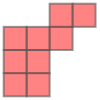

In [10]:
i=106
net_cdf = test_net_cdf[0]
shape=ws_shapes.geometry[i]
print("Gauge %s \n" % ws_shapes.name_en[i])

# get lon lat
shp_lon, shp_lat = shape.exterior.coords.xy

# build grid
from shapely import wkt
from shapely.geometry import Point

xmin, ymin, xmax, ymax = shape.exterior.bounds

length = 0.126
wide = 0.125

cols = list(np.arange(math.floor(xmin), math.ceil(xmax), wide))
rows = list(np.arange(math.floor(ymin), math.ceil(ymax), length))

polygons = []
test_nc = []
for x in cols[:-1]:
    for y in rows[:-1]:
        for example_x, example_y in zip(shp_lon, shp_lat):
            if Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]).contains(Point(example_x, example_y)):
                print('kek')
                polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))
                test_nc.append(net_cdf.where((net_cdf.lat==y) & (net_cdf.lon==x), drop=True))
                break
        
polygons = MultiPolygon(polygons)
polygons

Рисуем картинку для r.Maruha - s.Maruha



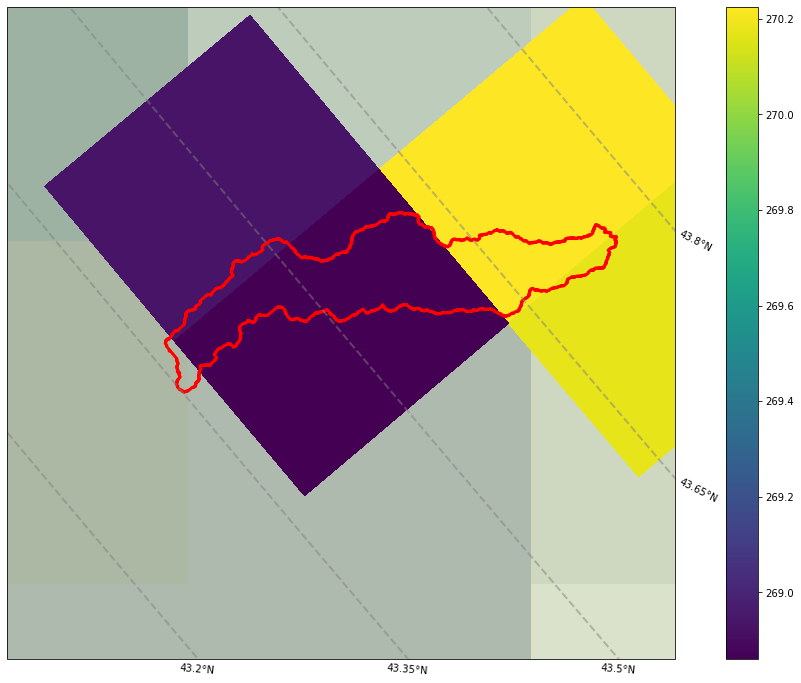

In [11]:
# shape=ws_shapes.geometry[i].simplify(0.25, preserve_topology=False)


print('Рисуем картинку для %s\n' % ws_shapes.name_en[i])
plot_nc_ws(net_cdf=mask_netcdf(net_cdf=test_net_cdf[0],
                               shape=cascaded_union(polygons)),
           WS=ws_shapes.geometry[i])

In [19]:
WS_nc = mask_netcdf(net_cdf=test_net_cdf[0],
                               shape=cascaded_union(polygons))

In [12]:
lat, lon = cascaded_union(polygons).exterior.coords.xy
mask = np.zeros_like(net_cdf, dtype=bool)

nc_lon, nc_lat = net_cdf.lon.values, net_cdf.lat.values
for j in range(nc_lat.size):    
    for i in range(nc_lon.size):
        if (net_cdf.lat.values[j] in lat) & (net_cdf.lon.values[i] in lon):
            mask[j,i] = True
mask = xr.DataArray(data=mask,
                    dims=['lat', 'lon'],
                    coords=[nc_lat, nc_lon])

WS_nc = net_cdf.where(mask, drop=True)

In [322]:
@jit(nopython=True, nogil=True)
def get_square(lon, step, lat):
    
    side = math.sqrt(step/2)

    x_adj = (step**2 + side**2 - side**2)/(2*step)
    y_adj = math.sqrt(side**2 - x_adj**2)
    
    x = lon - x_adj
    y = lat - y_adj
    x1, y1 = x, y + 2*y_adj
    x2, y2 = x + 2*x_adj, y
    x3, y3 = x + 2*x_adj, y + 2*y_adj
    
    return ((x, y), (x1, y1), (x2, y2), (x3, y3))

In [356]:
if 'time' in net_cdf.dims:
    mask = np.zeros_like(net_cdf[0], dtype=bool)
else:
    mask = np.zeros_like(net_cdf, dtype=bool)

In [320]:
lon = net_cdf.lon.values
lat = net_cdf.lat.values

In [116]:
from functools import reduce

def RotM(alpha):
    """ Rotation Matrix for angle ``alpha`` """
    sa, ca = np.sin(alpha), np.cos(alpha)
    return np.array([[ca, -sa],
                     [sa,  ca]])

def getSquareVertices(mm, h, phi):
    """ Calculate the for vertices for square with center ``mm``,
        side length ``h`` and rotation ``phi`` """
    hh0 = np.ones(2)*h  # initial corner
    vv = [np.asarray(mm) + reduce(np.dot, [RotM(phi), RotM(np.pi/2*c), hh0])
          for c in range(4)]  # rotate initial corner four times by 90°
    return np.asarray(vv)

In [323]:
target_point = 41.25

center = target_point, 43.

fourth = get_square(lon=target_point,
                   step=0.25,
                   lat=43)[0]
third = get_square(lon=target_point,
                   step=0.25,
                   lat=43)[1]

fifth = get_square(lon=target_point,
                   step=0.25,
                   lat=43)[2]

six = get_square(lon=target_point,
                 step=0.25,
                 lat=43)[3]

test_df = pd.DataFrame([center,*get_square(lon=target_point,
                                           step=0.25,
                                           lat=43)], columns=['x', 'y'])
test_df

,x,y
0,41.250,43.000000
1,41.125,42.669281
2,41.125,43.330719
3,41.375,42.669281
4,41.375,43.330719


In [122]:
def polygon_area(lats, lons, radius = 6378137):
    """
    Computes area of spherical polygon, assuming spherical Earth. 
    Returns result in ratio of the sphere's area if the radius is specified.
    Otherwise, in the units of provided radius.
    lats and lons are in degrees.
    """
    from numpy import arctan2, cos, sin, sqrt, pi, power, append, diff, deg2rad
    lats, lons = np.deg2rad(lats), np.deg2rad(lons)

    # Line integral based on Green's Theorem, assumes spherical Earth

    #close polygon
    if lats[0]!=lats[-1]:
        lats=append(lats, lats[0])
        lons=append(lons, lons[0])

    #colatitudes relative to (0,0)
    a = sin(lats/2)**2 + cos(lats)* sin(lons/2)**2
    colat = 2*arctan2( sqrt(a), sqrt(1-a) )

    #azimuths relative to (0,0)
    az = arctan2(cos(lats) * sin(lons), sin(lats)) % (2*pi)

    # Calculate diffs
    # daz = diff(az) % (2*pi)
    daz = diff(az)
    daz = (daz + pi) % (2 * pi) - pi

    deltas=diff(colat)/2
    colat=colat[0:-1]+deltas

    # Perform integral
    integrands = (1-cos(colat)) * daz

    # Integrate 
    area = abs(sum(integrands))/(4*pi)

    area = min(area,1-area)
    if radius is not None: #return in units of radius
        return area * 4 * pi* radius**2 / 10**6
    else: #return in ratio of sphere total area
        return area / 10**6

In [123]:
def select_big_from_MP(WS_geometry):
    
    """
    
    find biggest polygon in multipolygon
    exclude "fake" areas in watershed definition
    
    """
    
    if type(WS_geometry) == MultiPolygon:
        big_area = [polygon_area(lats = polygon.exterior.coords.xy[1], 
                                lons = polygon.exterior.coords.xy[0]) 
                    for polygon in WS_geometry]
        import numpy as np
        WS_geometry = WS_geometry[np.argmax(big_area)]
    else:
        WS_geometry = WS_geometry
    return WS_geometry

In [124]:
def create_GDF(shape):
    """
    
    create geodataframe with given shape
    as a geometry
    
    """
    gdf_your_WS = select_big_from_MP(WS_geometry=shape)
    ### WS from your data
    gdf_your_WS = gpd.GeoSeries([gdf_your_WS])

    ### Create extra gdf to use geopandas functions
    gdf_your_WS = gpd.GeoDataFrame({'geometry': gdf_your_WS})
    gdf_your_WS = gdf_your_WS.set_crs('EPSG:4326')
    
    return gdf_your_WS

# ВЫБор по EXTENT



In [108]:
def select_NC_by_extent(nc, shape):
    
    """
    
    select net_cdf by extent of given shape
    
    return masked net_cdf
    
    """
    
    if 'time' in nc.dims:
        nc = nc[0]
    else:
        pass
    
    # find biggest polygon
    big_shape = select_big_from_MP(WS_geometry=shape)

    # find extent coordinates
    min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=big_shape)
    
    # select nc inside of extent
    masked_nc = nc.where(
        nc.lat >= min_LAT, drop=True).where(
        nc.lat <= max_LAT, drop=True).where(
        nc.lon >= min_LON, drop=True).where(
        nc.lon <= max_LON, drop=True)
    
    return masked_nc

In [296]:
# find biggest polygon
big_shape = select_big_from_MP(WS_geometry=shape)

big_shape = create_GDF(shape=big_shape)

mask_nc = select_NC_by_extent(nc=net_cdf, shape=shape)

In [297]:
mask_nc

<xarray.DataArray 't2m' (lat: 3, lon: 3)>
dask.array<where, shape=(3, 3), dtype=float32, chunksize=(3, 3), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 41.25 41.5 41.75
  * lat      (lat) float64 43.75 43.5 43.25
    time     datetime64[ns] 1969-01-01

### Цикл с пересечением внутри выбора по EXTENT



In [132]:
nc_lat, nc_lon = mask_nc.lat.values, mask_nc.lon.values

In [288]:
polygons = list()
for j in range(nc_lat.size):
    for i in range(nc_lon.size):
        # h = 0.125 as a half of ERA5 resolution
        # phi rotation angle
        polygons.append(Polygon(getSquareVertices(mm=(nc_lon[i], nc_lat[j]),
                                                  h=0.125,
                                                  phi=0)))
# create geodataframe from each polygon from 
polygons = [create_GDF(poly) for poly in polygons]

intersected = [gpd.overlay(df1=big_shape, 
                           df2=poly, how='intersection') 
               for poly in polygons]

# find biggest intersection if it returns MultiPolygon instance
for i, section in enumerate(intersected):
    if section.empty:
        pass
    else:
        section['geometry'] = select_big_from_MP(section['geometry'][0])
        
# create mask for intersection with net_cdf
inter_mask = np.array([section.empty == False for section in intersected])
inter_mask = inter_mask.reshape(mask_nc.shape)
inter_mask = xr.DataArray(data=inter_mask,
                          dims=['lat', 'lon'],
                          coords=[nc_lat, nc_lon])
# create final instersection
WS_nc = mask_nc.where(inter_mask, drop=True)

In [226]:
np.ravel(np.zeros_like(mask_nc, dtype=bool))

array([False, False, False, False, False, False, False, False, False])

### Веса площадей

In [313]:
weights = [0 if section.empty
           else polygon_area(lats=section['geometry'][0].exterior.xy[1],
                             lons=section['geometry'][0].exterior.xy[0])/
           polygon_area(lats=shape.exterior.xy[1],
                        lons=shape.exterior.xy[0]) 
           for section in intersected]

In [314]:
weights

[0,
 0.2425932065610155,
 0.028177831149430108,
 0.06733096434637875,
 0.6339846897821999,
 0,
 0.0016589441035167296,
 0.02549199948993443,
 0]

In [519]:
@jit(nopython=True, nogil=True)
def get_square(lon, step, lat):
    
    side = math.sqrt(step/2)
#     step *= 2

    x_adj = (step**2 + side**2 - side**2)/(2*step)
    y_adj = math.sqrt(side**2 - x_adj**2)
    
    x0, y0 = lon - x_adj, lat - y_adj
    x1, y1 = lon - x_adj, lat + y_adj
    x2, y2 = lon + x_adj, lat - y_adj
    x3, y3 = lon + x_adj, lat + y_adj
    
    return ((x0, y0), (x1, y1), (x2, y2), (x3, y3))

In [547]:
test

array([[41.375, 43.625],
       [41.125, 43.625],
       [41.125, 43.375],
       [41.375, 43.375]])

In [544]:
get_square(lon=41.25, step=0.25, lat=43.5)

((41.125, 43.169281086116925),
 (41.125, 43.830718913883075),
 (41.375, 43.169281086116925),
 (41.375, 43.830718913883075))

In [169]:
draw_it = big_shape['geometry'][0]

In [185]:
polygons

,geometry
0,"POLYGON ((43.37900 41.12500, 43.37900 41.25000..."


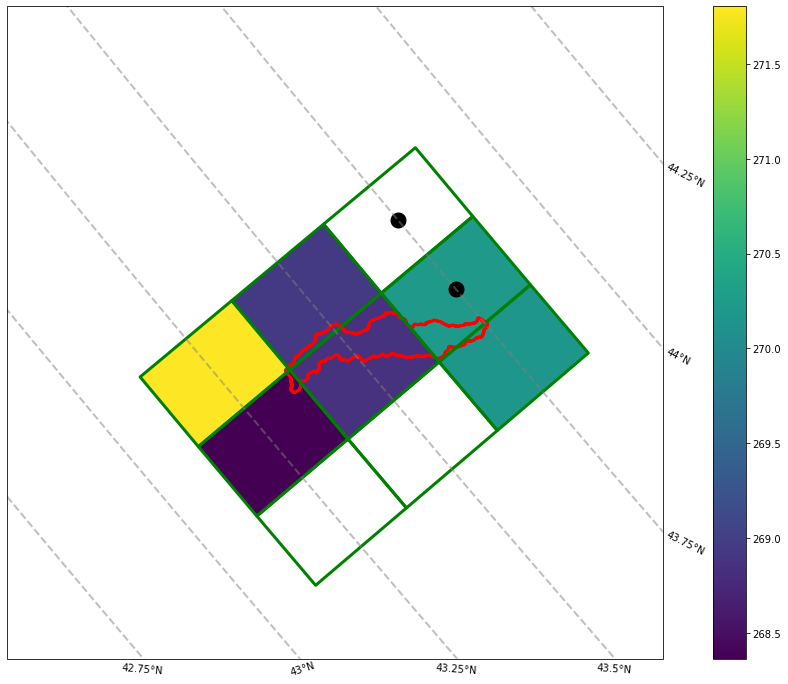

In [292]:
aea_crs = ccrs.AlbersEqualArea(central_longitude=100,
                              standard_parallels=(50, 70),
                              central_latitude=56,
                              false_easting=0,
                              false_northing=0)

merc_crs = ccrs.Mercator()


fig = plt.figure(figsize=(18,12))
ax = plt.axes(projection=aea_crs)

# min_LON, max_LON, min_LAT, max_LAT = find_extent(ws=polygons['geometry'][0])
min_LON, max_LON, min_LAT, max_LAT = 40.75, 42, 43, 44
# W, E, S, N
ax.set_extent([min_LON, max_LON, min_LAT, max_LAT],
              crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

gl.top_labels = False
gl.left_labels = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])


fig = plt.pcolor(WS_nc['lon'], WS_nc['lat'], WS_nc, 
                 shading='auto',
                 transform=ccrs.PlateCarree())

plt.colorbar(fig)

ax.add_geometries([big_shape['geometry'][0]],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='red',
                  linewidth=3)

ax.add_geometries([poly['geometry'][0] for poly in polygons],
                  crs=ccrs.PlateCarree(),
                  facecolor="None",
                  edgecolor='green',
                  linewidth=3)

# ax.add_geometries([res_intersection['geometry'][0]],
#                   crs=ccrs.PlateCarree(),
#                   facecolor="None",
#                   edgecolor='green',
#                   linewidth=3)

ax.scatter(x=[41.25, 41.5], 
           y= [43.75, 43.75],
           transform=ccrs.PlateCarree(),
           linewidth=10,
           facecolor='k')

# ax.scatter(x=[i[0] for i in get_square(lon=41.25, step=0.125, lat=43.75)],
#            y=[i[1] for i in get_square(lon=41.25, step=0.125, lat=43.75)],
#            transform=ccrs.PlateCarree(),
#            linewidth=10,
#            facecolor='c')


# ax.scatter(x=[i[0] for i in test],
#            y=[i[1] for i in test],
#            transform=ccrs.PlateCarree(),
#            linewidth=10,
#            facecolor='c')


ax.patch.set_alpha(0)

plt.show()

In [ ]:
for i, ws in enumerate(ws_shapes.geometry):
    print('Рисуем картинку для %s\n' % ws_shapes.name_en[i])
    plot_nc_ws(net_cdf=mask_netcdf(net_cdf=test_net_cdf[0],
                                   shape=cascaded_union(polygons)),
               WS=ws_shapes.geometry[i])

In [79]:
read_netcdf(list_of_files['2m_temperature'][0])[1].resample(time='1D').mean().chunk({'time':40})

<xarray.DataArray 't2m' (time: 365, latitude: 165, longitude: 689)>
dask.array<rechunk-merge, shape=(365, 165, 689), dtype=float32, chunksize=(40, 165, 689), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-01-02 ... 1958-12-31
  * longitude  (longitude) float32 19.0 19.25 19.5 19.75 ... 190.5 190.8 191.0
  * latitude   (latitude) float32 82.0 81.75 81.5 81.25 ... 41.5 41.25 41.0

In [78]:
ws_net_cdf = var_data.where(mask,
                            drop=True)

ws_net_cdf = ws_net_cdf.resample(time='1D').mean().chunk({'time':40})

NameError: name 'var_data' is not defined

In [8]:
def get_average_from_hours(net_cdf):
    
    """
    Function calculates average value for 24 hours
    
    Input is netcdf data
    """
    variable_name = list(net_cdf.variables)[-1]
    average_array = [net_cdf[variable_name][i:i+24, :, :].mean(dim='time')
                     for i in range(0, len(net_cdf[variable_name][:, :, :]), 24)]
    return average_array


def get_sum_from_hours(net_cdf):
    
    """
    Function calculates sum of values for 24 hours
    
    Input is netcdf data
    """
    
    variable_name = list(net_cdf.variables)[-1]
    average_array = [net_cdf[variable_name][i:i+24, :, :].sum(dim='time')
                     for i in range(0, len(net_cdf[variable_name][:, :, :]), 24)]
    
    return average_array

In [9]:
my_example_netcdf = (glob.glob('/mnt/e/ERA5_data/Russia/reanalysis-era5-single-levels-preliminary-back-extension/2m_temperature/*.nc')[0])

In [10]:
def read_netcdf(net_cdf_on_disk):
    
    dataset = xr.open_dataset(net_cdf_on_disk,
                              chunks={'time': 500})

    variable_name = list(dataset.variables)[-1]
    
    varible_data = dataset[variable_name]
    
    dataset.close()
    
    return variable_name, varible_data

In [11]:
var_name, var_data = read_netcdf(my_example_netcdf)

In [12]:
var_data

<xarray.DataArray 't2m' (time: 8760, latitude: 165, longitude: 689)>
dask.array<open_dataset-8ac4c02278ed8b3d75dd18166e48eeeet2m, shape=(8760, 165, 689), dtype=float32, chunksize=(500, 165, 689), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 19.0 19.25 19.5 19.75 ... 190.5 190.8 191.0
  * latitude   (latitude) float32 82.0 81.75 81.5 81.25 ... 41.5 41.25 41.0
  * time       (time) datetime64[ns] 1950-01-01 ... 1950-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [14]:
def mask_xarray(net_cdf, ws):

    """
    select values for one watershed
    and calculate mask based on lon, lat

    """
    net_cdf = net_cdf[0]
    
    # get lon, lat from net_cdf
    nc_lons, nc_lats = net_cdf['longitude'][:].values, net_cdf['latitude'][:].values

    # get lon, lat from watershed
    shp_lon, shp_lat = ws.exterior.coords.xy

    shp_lon, shp_lat = np.array(shp_lon), np.array(shp_lat)

    # Calculate mask
    mask = np.zeros_like(net_cdf, dtype=bool)

    mask = calc_mask(mask, nc_lons, nc_lats, shp_lon, shp_lat)

    mask = xr.DataArray(mask,
                        dims=['latitude', 'longitude'])
    return mask

In [15]:
ws_shape = ws_shapes.loc[0, 'geometry']

In [17]:
mask = mask_xarray(net_cdf=var_data,
                   ws=ws_shape)

ws_net_cdf = var_data.where(mask,
                           drop=True)

ws_net_cdf = ws_net_cdf.resample(time='1D').mean().chunk({'time':40})

In [18]:
ws_net_cdf

<xarray.DataArray 't2m' (time: 365, latitude: 7, longitude: 6)>
dask.array<rechunk-merge, shape=(365, 7, 6), dtype=float32, chunksize=(40, 7, 6), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1950-12-31
  * latitude   (latitude) float64 63.5 63.25 63.0 62.75 62.5 62.25 62.0
  * longitude  (longitude) float64 36.5 36.75 37.0 37.25 37.5 37.75

In [20]:
final_result = ws_net_cdf.load()

final_result = [np.nanmean(ws) for ws in final_result]

/home/dmbrmv/miniconda3/envs/geo/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [25]:
variable_name = 't2m'

In [27]:
final_df = pd.DataFrame(columns=['Date', '{}'.format(variable_name)])

In [30]:
final_df['Date'] = ws_net_cdf['time']
final_df['t2m'] = final_result
final_df

,Date,t2m
0,1950-01-01,246.536514
1,1950-01-02,249.959625
2,1950-01-03,242.995743
3,1950-01-04,242.844055
4,1950-01-05,241.474060
...,...,...
360,1950-12-27,262.966766
361,1950-12-28,258.270203
362,1950-12-29,253.046585
363,1950-12-30,249.544540


In [32]:
calculate_everything(net_cdf=var_data,
                     ws_shape=ws_shapes.loc[0, 'geometry'],
                     variable=var_name)

/home/dmbrmv/miniconda3/envs/geo/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,Date,t2m
0,1950-01-01,246.536514
1,1950-01-02,249.959625
2,1950-01-03,242.995743
3,1950-01-04,242.844055
4,1950-01-05,241.474060
...,...,...
360,1950-12-27,262.966766
361,1950-12-28,258.270203
362,1950-12-29,253.046585
363,1950-12-30,249.544540


In [31]:
def calculate_everything(net_cdf, ws_shape, variable):
    """
    Shp file for watershed borders
        
    """
    
    
    def mask_xarray(net_cdf, ws):

        """
        select values for one watershed
        and calculate mask based on lon, lat

        """
        net_cdf = net_cdf[0]

        # get lon, lat from net_cdf
        nc_lons, nc_lats = net_cdf['longitude'][:].values, net_cdf['latitude'][:].values

        # get lon, lat from watershed
        shp_lon, shp_lat = ws.exterior.coords.xy

        shp_lon, shp_lat = np.array(shp_lon), np.array(shp_lat)

        # Calculate mask
        mask = np.zeros_like(net_cdf, dtype=bool)

        mask = calc_mask(mask, nc_lons, nc_lats, shp_lon, shp_lat)

        mask = xr.DataArray(mask,
                            dims=['latitude', 'longitude'])
        return mask
    
    mask = mask_xarray(net_cdf=net_cdf, 
                       ws=ws_shape)
    
    ws_net_cdf = net_cdf.where(mask,
                               drop=True)
    
    ws_net_cdf = ws_net_cdf.resample(time='1D').mean().chunk({'time':40})
    
    final_result = ws_net_cdf.load()

    final_result = [np.nanmean(ws) for ws in final_result]
    
    final_df = pd.DataFrame(columns=['Date', '{}'.format(variable)])
    
    final_df['Date'] = ws_net_cdf['time']
    final_df['t2m'] = final_result
    
    return final_df

In [8]:


variable_name = list(dataset.variables)[-1]

# calculate dayli values
if variable_name == 't2m':
    daily_dataset = dataset.resample(time='1D').mean()
else:
    daily_dataset = dataset.resample(time='1D').sum()


dataset.close()

NameError: name 'dataset' is not defined

In [ ]:
ws_1_avg = get_average_from_hours(ws_1)

  0%|          | 0/10592 [00:00<?, ?it/s]

In [15]:
def get_average_from_hours(net_cdf):
    
    """
    Function calculates average value for 24 hours
    
    Input is netcdf data
    """
    variable_name = list(net_cdf.variables)[0]
    average_array = [net_cdf[variable_name][i:i+24, :, :].mean(dim='time').mean(dim=['longitude', 'latitude']).values
                     for i in tq.tqdm(range(0, len(net_cdf[variable_name][:, :, :]), 24))]
    return average_array

In [10]:
mask = mask_xarray(net_cdf=daily_dataset[variable_name][0], 
                   ws=ws_shapes.loc[0, 'geometry'])

ws_1 = daily_dataset.where(mask,
                           drop=True)
ws_1 = ws_1.mean(dim=['latitude', 'longitude'])

In [11]:
rechunked = ws_1['t2m'].chunk({'time': 500})

In [16]:
test = rechunked.isel(time=slice(None, 365))

In [17]:
test.to_dataframe()

,t2m
time,
1950-01-01,246.536514
1950-01-02,249.959625
1950-01-03,242.995743
1950-01-04,242.844055
1950-01-05,241.474060
...,...
1950-12-27,262.966766
1950-12-28,258.270203
1950-12-29,253.046570


In [ ]:
ws_1.t2m.load()

In [ ]:
ws_1['t2m'].to_netcdf('test.nc')

In [9]:
def mask_xarray(net_cdf, ws):
    
    """
    select values for one watershed
    and calculate mask based on lon, lat

    """
    
    # get lon, lat from net_cdf
    nc_lons = net_cdf['longitude'][:].values
    nc_lats = net_cdf['latitude'][:].values
    
    # get lon, lat from watershed
    shp_lon, shp_lat = ws.exterior.coords.xy

    shp_lon = np.array(shp_lon)
    shp_lat = np.array(shp_lat)
    
    # Calculate mask
    mask = np.zeros_like(net_cdf, dtype=bool)
    
    mask = calc_mask(mask, nc_lons, nc_lats, shp_lon, shp_lat)
    
    mask = xr.DataArray(mask,
                        dims=['latitude', 'longitude'])
    return mask

In [10]:
mask = mask_xarray(net_cdf=daily_dataset['t2m'][0], 
                   ws=ws_shapes.loc[0, 'geometry'])

In [ ]:
mean_ws_1 = ws_1.mean(dim=['latitude', 'longitude'])


In [ ]:
mean_ws_1

#### Для температур - среднее за 24 часа. Среднее для водосбора
#### Для испарения - сумма за 24 часа. Сумма для водосбора
#### Для потенц - сумма за 24 часа. Сумма для водосбора
#### Для стока - сумма за 24 часа. Сумма для водосбора
#### Для осадков - сумма за 24 часа. Сумма для водосбора

In [72]:
# read netcdf of 1 year
dataset = xr.open_dataset(my_example_netcdf,
                          chunks={'time': 1500})

# calculate dayli values
if list(dataset.variables)[-1] == 't2m':
    daily_values = get_average_from_hours(dataset)
else:
    daily_values = get_sum_from_hours(dataset)

# release memory
dataset.close()

In [82]:
def parallelize_function(net_cdf, ws, condition):
    
    """
    This function generate list of tuples
    where each tuple stands day from netcdf
    
    ws - GeoDataFrame of WS
    
    condition - mean or sum, depends on the variable
    
    """
    mp_tuples = list()
    
    for row in range(len(net_cdf)):
        mp_tuples.append((net_cdf[row],
                          ws,
                          condition))
    
    return mp_tuples


# generate data for starmap
data = parallelize_function(daily_values, test_ws, 'mean')

In [81]:
# prepare data and iterations on test example

# get count of cpu. Substract by 2 to not overwhelm system
function_processors = mp.cpu_count()//2

process_pool = mp.Pool(function_processors)

# masking ws, running through list of 
# tuples for function

output = process_pool.starmap(mask_xarray, tq.tqdm(data))
process_pool.close()
process_pool.join()


  0%|          | 0/365 [00:00<?, ?it/s]

In [83]:
import tqdm.notebook as tq

### first loop through folders

In [173]:
variables_store = glob.glob('/mnt/e/ERA5_data/Russia/reanalysis-era5-single-levels-preliminary-back-extension/*/')

# test
variables_store = variables_store[0]

### second loop through files

In [142]:
glob.glob('/mnt/e/ERA5_data/Russia/reanalysis-era5-single-levels-preliminary-back-extension/2m_temperature/*.nc')[0][-7:-3]

'1950'

In [149]:
final_output = pd.DataFrame(columns=['ID', 'ws_name', 'geometry'])

In [1]:
final_output

NameError: name 'final_output' is not defined

In [ ]:
# get count of cpu. Substract by 2 to not overwhelm system

function_processors = mp.cpu_count()//2

process_pool = mp.Pool(function_processors)

for i, ws_index in enumerate(ws_shapes.loc[0:2, 'geometry']):
    print('\nCalculating for {}\n'.format(ws_shapes.loc[i, 'name_en']))
    final_output.loc[i, 'ID'] = ws_shapes.loc[i, 'code']
    final_output.loc[i, 'ws_name'] = ws_shapes.loc[i, 'name_en']
    final_output.loc[i, 'geometry'] = ws_shapes.loc[i, 'geometry']
    
#     for variable_folder in tq.tqdm(variables_store, 'Going through folder variables'):
        
#         print(variable_folder)
        
    for files in tq.tqdm(glob.glob(variables_store + '/*.nc'), 'Reading each year'):

        # read dataset from each file
        dataset = xr.open_dataset(files,
                                    chunks={'time': 1500})

        dataset_variable = list(dataset.variables)[-1]
        # calculate daily values
        # average for t2m - rest is sum
        if dataset_variable == 't2m':
            daily_values = get_average_from_hours(dataset)
        else:
            daily_values = get_sum_from_hours(dataset)

        # release memory
        dataset.close()

        # generate data for starmap
        data = parallelize_function(net_cdf=daily_values, 
                                    ws=ws_shapes.loc[i, 'geometry'],
                                    condition='mean')

        # masking ws, running through list of 
        # tuples for function

        output = process_pool.starmap(mask_xarray, tq.tqdm(data, 'Calculating values for watershed'))
        process_pool.close()
        process_pool.join()

        final_output.loc[i, dataset_variable] = [output, files[-7:-3]]


Calculating for R.VODLA - D.VODLA



Reading each year:   0%|          | 0/29 [00:00<?, ?it/s]

Calculating values for watershed:   0%|          | 0/365 [00:00<?, ?it/s]

Process ForkPoolWorker-83:
Process ForkPoolWorker-79:
Process ForkPoolWorker-81:
Process ForkPoolWorker-84:
Process ForkPoolWorker-85:
Process ForkPoolWorker-80:
Process ForkPoolWorker-86:
Process ForkPoolWorker-82:


In [164]:
final_output

,ID,ws_name,geometry
0,48075.0,R.VODLA - D.VODLA,"POLYGON ((37.30708325000006 63.24041675000007,..."
1,48079.0,R.VODLA - G.PUDOJ,"POLYGON ((37.30708325000006 63.24041675000007,..."
2,72043.0,R.TOSNA - ST.TOSNO,"POLYGON ((30.91125000000005 59.55875000000003,..."


In [92]:


for i, ws_index in enumerate(ws_shapes['geometry']):
    final_output.loc[i, 'ID'] = ws_shapes.loc[i, 'code']
    final_output.loc[i, 'ws_name'] = ws_shapes.loc[i, 'name_en']
    final_output.loc[i, 'geometry'] = ws_shapes.loc[i, 'geometry']
    


,ID,ws_name,geom


In [ ]:
output

In [59]:
lats, lons = ws_1_avg[0]['latitude'][:], ws_1_avg[0]['longitude'][:]


/home/dmbrmv/miniconda3/envs/geo/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


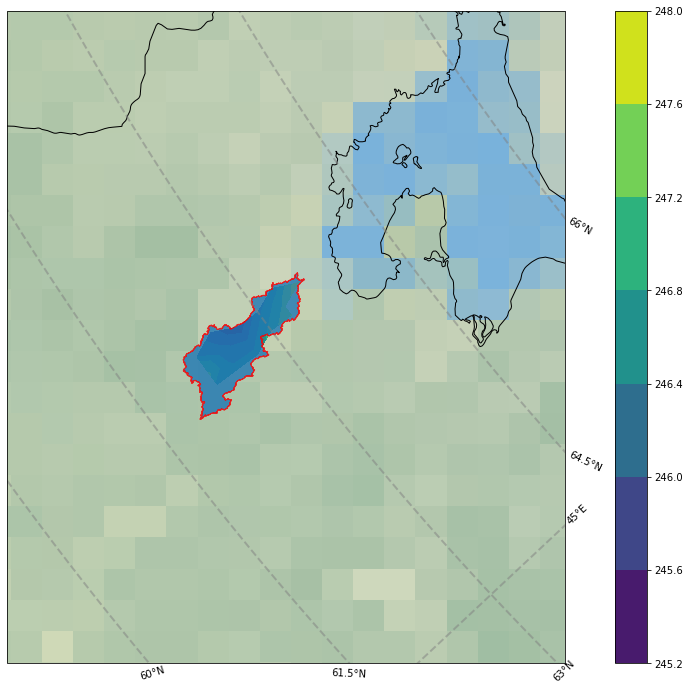

In [60]:
plot_check(extent=[30, 45, 64, 62],
           lat=lats,
           lon=lons,
           net_cdf_file=ws_1_avg[0],
           ws=ws_shapes.loc[0, 'geometry'].exterior)